## MECH 383 - Applied Electronics and Instrumentation

## Lab Information and Rules

1. All team members must be present for labs. Absences or time changes from scheduled labs need to be pre-arranged for valid reasons. 

2. It is strongly recommended to complete pre-labs before your experiment time. Pre-labs are handed in together with the experiment and lab report. 

3. Lab report due dates and late policy are given on the course syllabus. 

4. If your submission relies on additional files to run correctly, it is the responsibility of the student to ensure that all files are included with the submission and named correctly.

5. Labs are graded based on the output of each code block. Code that throws errors, supresses output, or otherwise results in **no printed output may not receieve points**.

6. Each lab will be handed in on behalf of the group by one group member.

**HINT**: To help ensure your notebook runs as expected, restart the kernel and re-run each cell sequentially.

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["font.family"] = "Times New Roman"

The following websites can be used as resources:

* https://www.python.org/
* https://numpy.org/
* https://matplotlib.org/


# MECH 383 - Lab 3

© Instructor-generated course materials (e.g., handouts, notes, summaries, exam questions, etc.) are protected by law and may not be copied or distributed in any form or in any medium without explicit permission of the instructor. 

##### Group Number:                
<br>Names: Stephen Chang, Zhi Ji Li, Simon Vaillant
<br>
<br> Collaborators: N/A
<br>
<br> Grade:  ________________/115

## Before starting:

During this lab, your team will have to upload code to an Arduino, and run python functions on your the lab desktop. Ensure at least one lab member has the Arduino IDE installed on their laptop, so you can modify the code before the lab.

Download information for the Arduino IDE can be found at https://www.arduino.cc/en/software 


## Pre-lab [Total: 20 points]

Submit all pre-lab questions and code one week before you attempt your lab.

 1. An encoder is a measurement device for linear or rotational motion. This specific motor (Bilda 5202-0002-0188) uses an incremental rotary motor at its gearbox output shaft. In your own words, explain how such an encoder works.

The encoder used on the motor is an incremental rotary encoder that uses the Hall effect. It uses either a pair of magnetic pickups or magnets fixed to a rotating disk paired with two Hall effect sensors. The rest of this explanation will assume a design with multiple magnets.

Two Hall effect sensors detect the strength of B field through themselves and output it as a voltage, which is then converted to a digital 1 or 0 when received by the Arduino's digital pin. Since a high voltage corresponds to a strong B field—i.e. a magnet is close to the sensor—the gaps between digital 1s corresponds to a discrete change in angle $\Delta\theta=\frac{360}{N_{magnets}}$. By counting how many digital 1s were output by the sensor over a time interval, one can calculate the change in angle of the motor assuming it does not change direction.

By installing 2 sensors with an offset of $(\frac{1}{2}+n)\Delta\theta$ (where n is an integer), the rotational direction of the motor can be determined by observing the phase shift between the outputs; a change in direction results in a flip of the phase shift.

In this experiment, the encoder indeed has 2 sensors with a count per revolution of 28, meaning that there are 28 magnets spaced equidistant on a disk mounted to the encoder shaft. This yields an angular resolution of $\Delta\theta=\frac{360°}{28\;\text{PPR}}=12.86°$ [1] [2].


2. a) Sample encoder data is provided in which a motor with a resolution of 8 counts/revolution makes exactly two counter-clockwise turns. Plot the raw sample data; label all axes.
<br>
<br> b) Write a python function that counts how far away the encoder is from its initial position, in terms of counts.
<br>
<br> c) Write a python function to distinguish the directions of motion. Validate the code by running it on the sample data; plot a graph with the prediction over time.
<br>
<br> d) Look up the resolution of the encoder you will use in this lab. How many degrees is one encoder count?


15


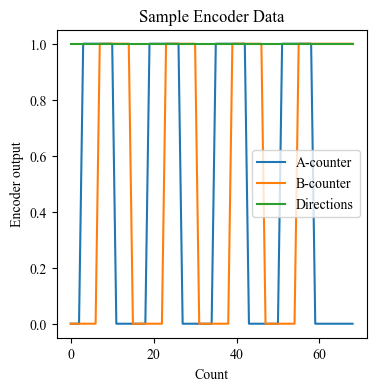

In [12]:
# a) Plotting sample data

SAMPLE_DATA_PATH = "sample_data.csv"

datas = np.array(pd.read_csv(SAMPLE_DATA_PATH)).transpose()

xs = np.arange(len(datas[0]))
ys1 = datas[0]
ys2 = datas[1]

fig1,ax1 = plt.subplots(figsize=(4,4))
ax1.set(
    title = "Sample Encoder Data",
    xlabel = "Count",
    ylabel = "Encoder output"
)

ax1.plot(xs, ys1,label="A-counter")
ax1.plot(xs, ys2,label="B-counter")
plt.show


# b) Counting encoder position

def position_counter(datas:np.array):
    count = 0
    last_value = 0
    for data in datas:
        for value in data:
            if value != last_value:
                count+=1
            last_value = value

    return count

print(position_counter(datas))

# c) Distinguishing direction

def get_directions(datas:np.array):
    ys1 = datas[0]
    ys2 = datas[1]
    # Let 1 be CCW and 0 be CW
    directions = []
    for i in range(len(ys1)):
        direction = 1
        try:
            if ys1[i]>ys1[i-1]:
                if ys2[i] == 0:
                    direction = 1
                else:
                    direction = 0
            elif ys1[i]<ys1[i-1]:
                if ys2[i] == 0:
                    direction = 0
                else:
                    direction = 1
        except IndexError:
            direction=1
        directions.append(direction)
    return directions

ax1.plot(xs, get_directions(datas),label="Directions")
legend = ax1.legend()

d) The resolution of the encoder is 5281 pulses per revolution (PPR) at the motor output shaft [1], which is 28 PPR of the encoder shaft. This means that the encoder reading occurs at 28 PPR, and the angle corresponding to one pulse is $\frac{360\degree}{28\;\text{PPR}} = 12.86\degree$ for the encoder, and $\frac{360\degree}{5281\;\text{PPR}} = 0.068\degree$ for motor shaft.


3. Explain what will happen to the encoder data as the motor changes speed. Sketch (by hand, tablet pen or photo of pen/pencil ok) how the encoder data plot would change when:
<br>
<br>a) The motor speeds up
<br>
<br>b) The motor slows down
<br>
<br>c) The motor stops


a) When the motor accelerates, the angular velocity of the encoder will in turn accelerate. This will lead to more successive triggers of the counters in the encoder, meaning gaps between digital 1 outputs will be spaced closer temporally. Graphically, the output will look horizontally compressed.

b) The inverse of a) will happen during deceleration: the peaks will become spaced further apart.

c) When the motor stops, the output positions of the counters will be constant: therefore they will form two horizontal lines at their corresponding outputs. These outputs may be identical or not depending on the position at which the motor was stopped.

<img src="Lab3Q3.jpg" alt="Lab3Q3" style="width:750px;"/>

The motor rotates in the CCW direction; encoder A leads encoder B. The motor first accelerates, then slows down, and finally stops.


4. The sample encoder data is not timestamped. Look up the speed range of your motor. How frequently would you need to sample the encoder measurements? Justify with an equation and a few sentences.


The no-load maximal speed of the motor is 30 RPM [1]. Since the encoder outputs at 5281 PPR, the pulse frequency should be $30 RPM\;\cdot\;\frac{1\;min.}{60\;s}\;\cdot\;5281 PPR = 2640.5\;Hz$. By the Nyquist criterion, a rate greater than 5281 Hz should be employed.


5. The Arduino Uno microcontroller communicates with the computer through the serial port at a Baud rate of 9600.
<br>
<br>a) Theoretically, how many bits of information can be transferred each second?
<br>
<br>b) Assuming the information is sent as characters (one byte per chatacter), how many characters can be transferred each second?
<br>
<br>c) Assuming the motor is operating at full speed, can the serial port transfer information for both encoders at a fast enough rate?


a) Since the encoder transmits binary outputs (0 or 1), the baud rate is equivalent to the bit rate. This means that the theoretical bit rate is 9600 bits per second.

b) Since one ASCII character is 1 byte—i.e.8 bits—each character can be transferred at 9600 / 8 = 1200 bytes per second.

c) No; assuming each character only encodes the output of each encoder at a single point in time (i.e. no "bulk" data transmission), the character transfer speed is inadequate as it's lower than the Nyquist rate of 5281 Hz.


6. The Arduino UNO can perform on-board calculations at a much faster rate than the serial transfer. Attached is sample Arduino code. At its start, the code assigns dummy variable ''pos'' a value of zero. Every time Encoder A changes position from LOW to HIGH, the provided code increases variable ''pos'' by one. Every 1 s, the microcontroller transmits the value of ''pos'' over the serial port to the computer.
<br>
<br>a) This code does not capture the full resolution of the encoder. Edit the code to calculate the actual encoder position, in units of counts. Ensure that it is taking into account information from both encoders.
<br>
<br>b) Decide on a more appropriate transmission frequency than 1 Hz. Justify your choice of sampling rate.
<br>
<br>c) In the top left of the arduino IDE, press "Validate" to ensure your code will run smoothly.


a) To account for the full resolution, both the on and off states of ENCODER_A must be individually evaluated. Technically, one could measure "half counts" if the state changes of ENCODER_B were also measured—assuming the Hall effect sensors are spaced correctly (this can easily be tested by running the encoder at constant speed and checking whether the encoder outputs are +-90° apart).

b) Ideally, a sampling rate greater than the Nyquist rate of 5281 Hz would be used. This would then require a higher baud rate than 9600. Looking at documentation for the ATmega328P datasheet, it is evident that the chip is capable of much greater baud rates than 9600:

<img src="ATmega328PDatasheet.png" alt="ATmega328PDatasheet.png" style="width:500px;"/>

A baud rate of 76 800 bps and sampling rate of 7500 Hz would therefore be more appropriate. (Note that the ATmega328P has a fixed clock speed of 16 MHz)

Unfortunately, during the lab, the baud rate was unchanged and—more importantly—the sampling rate was set to 14 Hz. This was partially due to an attempt to debug what ended up being a hardware problem of the encoder; "safe" values (such as low sampling rates) were therefore used to try to solve the problem.


7. See the attached Python code to receive data sent by the microcontroller over the serial port. Edit the code to save the data in the location of your choice, keeping the appropriate number of significant figures that you choose. Edit your output in a format that is compatible with your python function in Q2. Ensure that your saved files have time-stamped encoder data. Running the python code from your command line, if all packages are installed, and it is not yet connected to an Arduino, it should return "Error during initialization : Microcontroller not found".
<br>
<br>Submit both your updated Python and Arduino codes to mycourses with your pre-lab.


8. The motor setup suggested requires a fancy power supply. Why can't you just plug the motor power cables into the Arduino directly? Explain using quantities in the motor's data sheet.


The motor cannot be plugged into the Arduino as it cannot provide enough current/voltage. The motor operates at 12 VDC (arduino outputs a max of 5 V) and draws up to 9.2 A @ stall (although in practice it should be somewhere in between 9.2 and 0 A, where $I_{motor}=\frac{motor\space RPM}{30\thinspace\text{RPM}}\cdot9.2\thinspace\text{A}$).


9. Look at the motor driver data sheet. Find the data sheet of the H-bridge that's inside the motor driver. Using the H-bridge's data sheet, describe 3 factors that could damage the transistors in the half-bridge.


Since all motor power current runs through the MOSFETs' source and drain, they are susceptible to thermal damage if overloaded with current; the datasheet indicates a peak current capacity of 43 A. Sustained operation at 43 A or greater is likely to permenantly damage those MOSFETs.

The datasheet also indicates a maximum input voltage of 27 V. A greater voltage input, even if the gate is off, may allow current to jump across the depletion region if it is above its breakdown voltage.

Finally, a shorting of the H-bridge would also cause a pair of MOSFETs to sustain thermal damage. Indeed, the input voltage and resulting current would bypass the motor entirely; this current would likely be much greater than 43 A [3].

## List of Parts

Please make sure that all of the following supplies are on your bench:

1. Power supply
2. Motor (Bilda 5202-0002-0188)
3. Motor Driver (H-039/BTS7960)
4. Arduino UNO
5. Breadboard with potentiometer
6. Lab desktop with python and Arduino functions open (serial_interface.py, motor_control.ino)
7. Assorted wires.
8. 500 g and 1000 g masses. 




## Lab Instructions

### Setting up logging and arduino code

Step 1: On the lab desktop, open Pycharm and navigate to the local copy of the lab folder **Note: downloads will appear in the H: drive**

Step 2: Open the serial_interface.py file

Step 3: Click Settings and type python interpreter in the search bar

Step 4: Click the + symbol to add a new package and search for pyserial

Step 5: Click install pyserial and wait until the package is installed

Step 6: Connect the USB-C cable to the arduino board and open the arduino IDE

Step 7: Compile and upload your arduino code to the board

Step 8: In Pycharm run the serial_interface.py file and ensure there are no errors. If done correctly, the terminal window should start printing out the data obtained from the arduino board.

Step 9: Terminate the python code by clicking on the red button in the **terminal window**

![Motor Circuit Setup](circuit_diagram_v1.svg "Motor Circuit Setup")

### Lab Instructions 

Step 1: Confirm the signal wires are properly connected, per the diagram. Confirm that Ch.A is connected to Digital Port 2, and Ch.B connected to Digital Port 3 on the Arduino.

Step 2: Turn on the power supply and ensure the voltage is set to 12V.

Step 3: Load and run your encoder measurement Arduino code to the microcontroller. The motor might start turning. If it does, turn the potentiometer to an approximately "centre" position, until the motor stops. Once your code is uploaded to the Arduino, close the Arduino IDE.

Step 4. Run your python logging code. Slowly turn the potentiometer to increase the speed. Controlling the potentiometer, make the pulley complete exactly one full turn (or as close as possible), then turn the potentiometer back to bring the pulley to rest. Stop the logging code (Ctrl+C on most terminals). 

Step 5. Confirm the location of the log file. Be sure to clearly indicate which folder is associated with which step of your lab (taking personal notes, changing file or folder names). This is good practice after every time you save a file in this lab. 

Step 6: Run the python logging script again. This time, turn the potentiometer to a few different positions, for a reasonable amount of time, until you have found the highest clockwise and counter-clockwise speeds. Ensure any parts attached to the pulley and fishing line do not hit the table or floor. Throughout this run, note any changes in voltage or current from the power supply as the potentiometer changes (qualitatively). When the potentiometer is set to the highest counter-clockwise speed, turn off the power supply then stop the code to save your results.

Step 7: With the power supply turned off, if it is not already attached, connect the carabiner to the fishing line. Set the carabiner close to the ground, and ensure the fishing line is wound around the pulley. Ensure the potentiometer is at the position to set the highest counter-clockwise speed. 

Step 8: Start your python logging script, then turn the power supply on, to turn the pulley. After a few seconds, when the carabiner is nearing the pulley, turn the potentiometer to a neutral position to stop the pulley, then turn the power supply off and stop the code. Throughout this run, have a labmate note, approximately, the voltage and current drawn from the power supply.

Step 9: Re-set the pulley position to slightly above the floor. This can be done by turning the power supply on with the potentiometer in the opposite direction. Set the potentiometer to a neutral position, with the motor not turning, then turn the power supply off. Once the power is turned off, re-set the potentiometer to the highest counter-clockwise speed.

Step 10: Attach the 500g mass to the carabiner. Repeat Steps 10 and 11. For safety, ensure you stop the carabiner before it hits the pulley. Ensure a labmate records any differences in voltage or current with the heaier payload.

Step 11: Replace the 500 g mass with the 1000 g mass. Repeat Steps 10 and 11. For safety, ensure you stop the carabiner before it hits the pulley. Ensure a labmate records any differences in voltage or current with the heaier payload.

Step 12: Remove the mass from the carabiner, ensure the power supply is turned off

Step 13: In the Arduino IDE open a new file and upload it to the arduino board. After the code is uploaded disconnect the USB-C cable from the board.

## Lab Report [90 Points]

1. Look at the circuit diagram of the motor driver. Describe qualitatively what role the MOSFETS have.

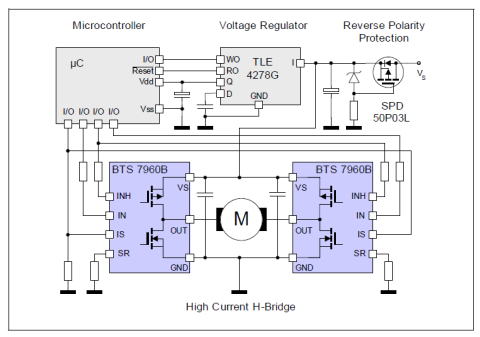

The MOSFETs act as a toggle between forward and reverse rotation of the motor. Looking closely, there are diagonal pairs of NMOS and PMOS transistors, which allow a negative or positive voltage to determine the direction of rotation. This is similar to the way a rectifier works.


2. a) Look at the circuit diagram of the potentiometer. Calculate the voltage sent to the microcontroller; give your answer as a formula.
<br>
<br>b) From reviewing the Arduino code, briefly explain how the microcontroller converts a signal from the potentiometer into a signal to the motor controller.

In [ ]:
# a) Voltage drop =  5V: potentiometer acts as a voltage divider.
# Output voltage = angle/

# b) First, analogueRead is used to convert the 0–5V signal to a digital 0-1023.
# Then, it is arbitrarily defined that 1023 (i.e. full CW rotation of the potentiometer)
# is full forward and 0 is full reverse. Using this, the code then sends the corresponding
# PWM signal to the motor controller (within [0,256]).

3. Plot your data from Step 6; use axis titles and units of counts. Explain whether your Arduino code was capturing the full resolution of the encoder for one full rotation, or a multiple of its values.

In [ ]:
## Display your graphs here
slowCW_logs = pd.read_csv("log_slowSpeedCW.csv")
slowCCW_logs = pd.read_csv("log_slowSpeedCCW.csv")
medCW_logs = pd.read_csv("log_medSpeedCW.csv")
medCCW_logs = pd.read_csv("log_medSpeedCCW.csv")
fastCW_logs = pd.read_csv("log_highSpeedCW.csv")
fastCCW_logs = pd.read_csv("log_highSpeedCCW.csv")

slow_CW_pos_and_encoders = slowCW_logs.iloc[:,2:5].to_numpy()
slow_CW_pos_and_encoders[:,0] = slow_CW_pos_and_encoders[:,0] / 2.0
slow_CCW_pos_and_encoders = slowCCW_logs.iloc[:,2:5].to_numpy()
slow_CCW_pos_and_encoders[:,0] = slow_CCW_pos_and_encoders[:,0] / 2.0
med_CW_pos_and_encoders = medCW_logs.iloc[:,2:5].to_numpy()
med_CW_pos_and_encoders[:,0] = med_CW_pos_and_encoders[:,0] / 2.0
med_CCW_pos_and_encoders = medCW_logs.iloc[:,2:5].to_numpy()
med_CCW_pos_and_encoders[:,0] = med_CCW_pos_and_encoders[:,0] / 2.0
fast_CW_pos_and_encoders = fastCW_logs.iloc[:,2:5].to_numpy()
fast_CW_pos_and_encoders[:,0] = fast_CW_pos_and_encoders[:,0] / 2.0
fast_CCW_pos_and_encoders = fastCCW_logs.iloc[:,2:5].to_numpy()
fast_CCW_pos_and_encoders[:,0] = fast_CCW_pos_and_encoders[:,0] / 2.0

sample_rate = 14 # Hz
pos = {'slowCW': [], 'slowCCW': [], 'medCW': [], 'medCCW': [], 'fastCW': [], 'fastCCW': []}
EncoderA = {'slowCW': [], 'slowCCW': [], 'medCW': [], 'medCCW': [], 'fastCW': [], 'fastCCW': []}
EncoderB = {'slowCW': [], 'slowCCW': [], 'medCW': [], 'medCCW': [], 'fastCW': [], 'fastCCW': []}
counts = {'slowCW': [], 'slowCCW': [], 'medCW': [], 'medCCW': [], 'fastCW': [], 'fastCCW': []}

# in units of output shaft degrees / second
rot_speed = {'slowCW': [], 'slowCCW': [], 'medCW': [], 'medCCW': [], 'fastCW': [], 'fastCCW': []}

log_list = [slow_CW_pos_and_encoders, slow_CCW_pos_and_encoders, med_CW_pos_and_encoders,
            med_CCW_pos_and_encoders, fast_CW_pos_and_encoders, fast_CCW_pos_and_encoders]

for k in range(6):
    x = list(pos.keys())[k]
    for i in range(len(log_list[k])-5):
        pos[x].append(log_list[k][i+1,0] - log_list[k][i,0])
        rot_speed[x].append(pos[x][i] * sample_rate * 360 / 5281) # to get output shaft degrees/second
        EncoderA[x].append(log_list[k][i,1])
        EncoderB[x].append(log_list[k][i,2])
        counts[x].append(i+1)

slow_fig, slow_ax = plt.subplots(nrows=4, ncols=1, figsize=(11,11), layout='constrained')
slow_ax[0].set_title('CW Slow Speed Encoder Values')
slow_ax[0].plot(counts['slowCW'][:100], EncoderA['slowCW'][:100])
slow_ax[0].plot(counts['slowCW'][:100], EncoderB['slowCW'][:100])
slow_ax[0].set_xlabel('Sample Count')
slow_ax[0].set_ylabel('Encoder Values')
slow_ax[2].set_title('CCW Slow Speed Encoder Values')
slow_ax[2].plot(counts['slowCCW'][:100], EncoderA['slowCCW'][:100])
slow_ax[2].plot(counts['slowCCW'][:100], EncoderB['slowCCW'][:100])
slow_ax[2].set_xlabel('Sample Count')
slow_ax[2].set_ylabel('Encoder Values')
slow_ax[1].set_title('CW Slow Speed Output Shaft Angular Speed')
slow_ax[1].plot(counts['slowCW'][:100], rot_speed['slowCW'][:100])
slow_ax[1].set_xlabel('Sample Count')
slow_ax[1].set_ylabel('Output Shaft Angular Speed (degrees/second)')
slow_ax[3].set_title('CCW Slow Speed Output Shaft Angular Speed')
slow_ax[3].plot(counts['slowCCW'][:100], rot_speed['slowCCW'][:100])
slow_ax[3].set_xlabel('Sample Count')
slow_ax[3].set_ylabel('Output Shaft Angular Speed (degrees/second)')

med_fig, med_ax = plt.subplots(nrows=4, ncols=1, figsize=(11,11), layout='constrained')
med_ax[0].set_title('CW Medium Speed Encoder Values')
med_ax[0].plot(counts['medCW'][:100], EncoderA['medCW'][:100])
med_ax[0].plot(counts['medCW'][:100], EncoderB['medCW'][:100])
med_ax[0].set_xlabel('Sample Count')
med_ax[0].set_ylabel('Encoder Values')
med_ax[2].set_title('CCW Medium Speed Encoder Values')
med_ax[2].plot(counts['medCCW'][:100], EncoderA['medCCW'][:100])
med_ax[2].plot(counts['medCCW'][:100], EncoderB['medCCW'][:100])
med_ax[2].set_xlabel('Sample Count')
med_ax[2].set_ylabel('Encoder Values')
med_ax[1].set_title('CW Medium Speed Output Shaft Angular Speed')
med_ax[1].plot(counts['medCW'][:100], rot_speed['medCW'][:100])
med_ax[1].set_xlabel('Sample Count')
med_ax[1].set_ylabel('Output Shaft Angular Speed (degrees/second)')
med_ax[3].set_title('CCW Medium Speed Output Shaft Angular Speed')
med_ax[3].plot(counts['medCCW'][:100], rot_speed['medCCW'][:100])
med_ax[3].set_xlabel('Sample Count')
med_ax[3].set_ylabel('Output Shaft Angular Speed (degrees/second)')

fast_fig, fast_ax = plt.subplots(nrows=4, ncols=1, figsize=(11,11), layout='constrained')
fast_ax[0].set_title('CW Fast Speed Encoder Values')
fast_ax[0].plot(counts['fastCW'][:100], EncoderA['fastCW'][:100])
fast_ax[0].plot(counts['fastCW'][:100], EncoderB['fastCW'][:100])
fast_ax[0].set_xlabel('Sample Count')
fast_ax[0].set_ylabel('Encoder Values')
fast_ax[1].set_title('CW Fast Speed Output Shaft Angular Speed')
fast_ax[1].plot(counts['fastCW'][:100], rot_speed['fastCW'][:100])
fast_ax[1].set_xlabel('Sample Count')
fast_ax[1].set_ylabel('Output Shaft Angular Speed (degrees/second)')
fast_ax[2].set_title('CCW Fast Speed Encoder Values')
fast_ax[2].plot(counts['fastCCW'][:100], EncoderA['fastCCW'][:100])
fast_ax[2].plot(counts['fastCCW'][:100], EncoderB['fastCCW'][:100])
fast_ax[2].set_xlabel('Sample Count')
fast_ax[2].set_ylabel('Encoder Values')
fast_ax[3].set_title('CCW Fast Speed Output Shaft Angular Speed')
fast_ax[3].plot(counts['fastCCW'][:100], rot_speed['fastCCW'][:100])
fast_ax[3].set_xlabel('Sample Count')
fast_ax[3].set_ylabel('Output Shaft Angular Speed (degrees/second)')

plt.show()

<img src="Q6_slow.png" alt="ATmega328PDatasheet.png" style="width:500px;"/>
<img src="Q6_med.png" alt="ATmega328PDatasheet.png" style="width:500px;"/>
<img src="Q6_fast.png" alt="ATmega328PDatasheet.png" style="width:500px;"/>

Due to the very low sampling rate used for the experiments, the full resolution of the encoders was not realized in the Arduino data output. This caused significant alising errors in any analysis based off the encoder readings, including both speed and direction determination.
Rather, at lower speeds, a smaller multiple of the encoder's full resolution was observed due to the relatively smaller ratio between the sampling frequency and the minimum (Nyquist) sampling frequency at the given speed. Conversely, at the highest speeds in both directions, larger multiples of the full resolution of the encoder were captured due to the higher ratio between the experimental sampling frequency and the Nyquist sampling frequency.

4. Plot your data from Step 8. Using this data, calculate the rotational speed of the motor across the test, in degrees/sec. Show your result on a graph.

In [ ]:
## Display your graphs, functions and calculations here
## Use print() to display your final answer

5. Calculate the torque applied to the motor in Steps 10-13. Note that the pulley has a diameter of 200 mm, and the carabiner has a mass of 100 g. 

In [ ]:
# carabiner mass = 100 g = 0.1 kg, D = 200 mm = 0.2 m

iter1 = round(0.2*0.1*9.81,3)
iter2 = round(0.2*(0.1+0.5)*9.81,3)
iter3 = round(0.2*(0.1+1)*9.81,3)


# Step 8:
print("The torque applied at Step 8 with no load is", str(iter1), "Nm.")

# Step 10:
print("The torque applied at Step 10 with a 500 g load is", str(iter2), "Nm.")

# Step 11:
print("The torque applied at Step 11 with a 1000 g load is", str(iter3), "Nm.")

The torque applied at Step 8 with no load is 0.196 Nm.
The torque applied at Step 10 with a 500 g load is 1.177 Nm.
The torque applied at Step 11 with a 1000 g load is 2.158 Nm.


6. Using your encoder data from steps 10-13, calculate the speed (in rpm) of the motor in for each different weight; print your results. Smoothing the data with the algorithm of your choice is strongly recommended. Discuss how you smoothed your data, and why. 

In [ ]:
# Given that our experimental setup was not functioning correctly in the lab, we did not have enough
# time to collect the encoder data for the experiment. However, the result should theoretically 
# follow the relationship where

torque_applied = [iter1,iter2,iter3]
torque_stall = 250*9.81/100 # in Nm
angular_speed = list()
for torque in torque_applied:
    angular_speed.append(round((1 - torque/torque_stall) * 30,3)) # in RPM
print('The expected angular speeds of the motor at different loads of 100g, 600g, and 1100g, are ' +
      str(angular_speed[0]) + 'RPM, '+ str(angular_speed[1]) +'RPM, and ' + str(angular_speed[2]) + 'RPM.')

# This would have been obtained by graphing the logged position counter from the Arduino script and scaling it by 
# the calculated angular resolution of the encoder. The slope of curve would be the angle over time, which is the 
# angular speed of the output shaft.

The expected angular speeds of the motor at different loads of 100g, 600g, and 1100g, are 29.76RPM, 28.56RPM, and 27.36RPM.


7. Look at the documentation of the motor. Explain what happened when you attached a heavier mass to the motor (1000 g vs 0 g). What would happen if the mass was 5000 g? 50 kg? What attached mass would be needed to cause complications?

<!-- Based on our collected data from the power supply, the power draw is positively correlated with the mass. This means that a 5 kg or 50 kg mass would drastically increase the power required by the motor.-->
<!-- I don't think this^ is necessary/true; as you said, stall occurs at 12.5, meaning that at 50 kg the motor should draw less current/power-->


From the motor data sheet, the its 12 V stall characteristics are a current draw of 9.2 A and torque of 250 kg cm:

250 kg cm / 20 cm = 12.5 kg.

At this theoretical load, the shaft would remain stationary with 9.2 A of current running through its coils. This would likely result in thermal damage of the components of the motors, as they are not usually designed to operate at max voltage stall for prolonged periods. However, the H-bridge has a max current draw of 43 A, meaning it is unlikely to be damaged.

8. Detailed torque-speed data is provided in an auxiliary file. Using the torques and angular speeds calculated in steps 10-13, create a plot that overlays your measurements with the provided data. Explain any agreement and/or discrepancies.

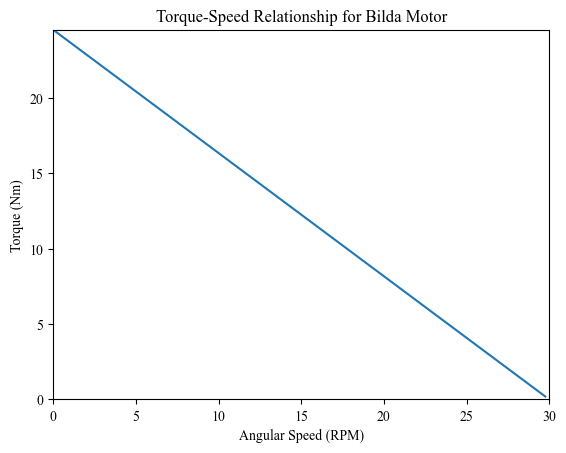

In [ ]:
# The torque speed data is not provided. A plot will be generated anyway:

fig, ax = plt.subplots()
x_values = angular_speed
x_values.append(0)
y_values = torque_applied
y_values.append(torque_stall)

ax.plot(x_values,y_values)
plt.xlabel("Angular Speed (RPM)")
plt.xlim(0,30)
plt.ylim(0,torque_stall)
plt.ylabel("Torque (Nm)")
plt.title("Torque-Speed Relationship for Bilda Motor")
plt.show()

*Type your answer here*

9. Check the time intervals between your recorded data points. Are they consistent? Compare the actual sampling frequency to the intended frequency, and discuss any discrepancies.

*Type your answer here*

10. Qualitatively, did you notice any changes in voltage or current as the potentiometer reading changed? Did any changes occur as the mass of the payload increased? Discuss these results and how they relate to the motor's documentation.

The voltage and current did not change drastically due to changes in the potentiometer. This is because the potentiometer behaves like a voltage divider: the potentiometer angle changes the potential difference between the two outputs, but it does not modify the supplied voltage and current.

The current and voltage did fluctuate substantially when the different masses were loaded on the carabiner. While our voltage had very small changes, the current drawn incresed when more mass was added to the carabiner. Since all the masses were lifted at the maximum speed, this coincides with a higher power requirement to generate an appropriate torque to lift the mass. SInce P = Tw = VI, then an increase in current leads to an increase in torque.

Bonus question: Consider a scenario where this motor has to drive a factory conveyor belt with 50lbs on it. Assuming a friction coefficient of 0.3, what is the maximum radius of belt rollers that would enable this motor to drive it?

In [ ]:
## As the question is seemingly vaguely worded, here are 2 interpretations of the problem and their respective solutions.


## Solution 1: It is assumed that the conveyor belt is at an angle and moves loads uphill. The friction coefficient of 0.3 between the belt and
## the loads means that there is some max angle above which loads can't be pushed up; they'd slide down due to lack of friction. Then,
## from this angle, we calculate the max roller radius such that the torque of the motor is sufficient to move them up.

# First, we find the (static) friction force at the angle at which the 50 lb load is about to slide.
# Any less angle and the static friction force=Fg_x' decreases; any more angle and the
# kinetic friction=mu*N=mu*Fg_y' decreases. To do so, we solve for
# f = Fg_x'
# mu*Fg_y' = Fg_x'
# arctan(mu) = theta
# => f = Fg*sin(arctan(mu)) = Fg*sqrt(1+mu^2)       (some trig identities)
# then we use T = f * R to find the max radius

# 50 lbs was converted to 22.68 kgf
f = 22.68*math.sqrt(1+0.3**2)
R = np.round(250/f,3)

print("Solution 1: The maximum belt roller radius is ",R," cm")


## Solution 2: It is assumed that the conveyor belt is flat (horizontal) and that we are looking for the maximum pulley radius such that the
## system is friction-limited rather than torque-limited (i.e. such that below this roller radius, accelerating loads from rest will cause
## them to slip before reaching the motor's torque limit).

# This is much simpler; simply set
# T = f * R

# 50 lbs are again converted to 22.68 kgf
R = np.round(250/(0.3*22.68))

print("Solution 2: The maximum belt roller radius is ",R," cm")


## We do believe that solution 1 was more likely to be the intended interpretation of the problem

Solution 1: The maximum belt roller radius is  10.558  cm
Solution 2: The maximum belt roller radius is  37.0  cm


## References [5 points]

Please share any resources that you used (ex: Stack Overflow, official documentation, myCourses forum, etc) and the names of anyone you worked with. For resources, provide a URL where necessary. For collaborators, note which sections were done collaboratively; failure to do so may result in a grade of 0/5 for references.

[1] *5202 Series Yellow Jacket Planetary Gear Motor*. 5202-0002-0188. Rev. 1. Base 10 Assets, LLC. May 2023. Available: https://www.gobilda.com/content/spec_sheets/5202-0002-0188_spec_sheet.pdf

[2] “Incremental encoders,” Avtron Encoders, https://www.nidec-avtronencoders.com/incremental-encoders/ (accessed Nov. 24, 2025). 

*BTS7960 High Current 43A H-Bridge Motor Driver*. DRV-1012. Rev. 1. Handson Technology. Oct. 2025. Available: https://www.handsontec.com/dataspecs/module/BTS7960%20Motor%20Driver.pdf

“What is motor stall – stall current and stall torque,” Wira Electrical, https://wiraelectrical.com/what-is-motor-stall/ (accessed Nov. 24, 2025). 

